# Capstone II DJIA and Reuters articles
# Milestone Report I
Charita Ramnathsing July 2020

# Goals:
    compile a data set, wrangled and cleaned it
    explore it with descriptive statistics and visualization techniques
    explore it with inferential statistics techniques.


In [46]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show

import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

import string
from datetime import datetime
import statistics 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

from textblob import TextBlob

import sys
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [47]:
#read files
DJIA = pd.read_csv(
        "DJI_2018.csv",
        parse_dates=['Date']
    )

df_text = pd.read_csv('reuters_articles_for_prediction.csv', usecols=['date','year', 'month', 'day', 'title', 'publication'])



In [48]:
# filter only the Reuters articles
df_text = df_text[df_text.publication == 'Reuters']

In [49]:
# drop the columns which are not needed 
df_reuters = df_text.drop(['month', 'day', 'publication'], axis=1)

In [50]:
# filter articles for only the year '2018'
text_2018 = df_reuters[df_reuters['year'] == 2018].sort_index().drop('year', axis=1).reset_index()

In [51]:
punc = list(set(string.punctuation))

In [52]:
porter = PorterStemmer()
lemma = nltk.stem.wordnet.WordNetLemmatizer()

In [53]:
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

In [54]:
def process_text(text):
    text = text.replace("U.S.", "usa")
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+-', '', each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in ENGLISH_STOP_WORDS]
    text = [each for each in text if len(each) > 1]
    text = [lemma.lemmatize(each) for each in text if not each.isnumeric()]
    return text


In [55]:
vectorizer = TfidfVectorizer(max_df= 0.1, tokenizer = process_text, stop_words = ENGLISH_STOP_WORDS)
tdm = vectorizer.fit_transform(text_2018.title)

In [56]:
freqs = {word: tdm.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}

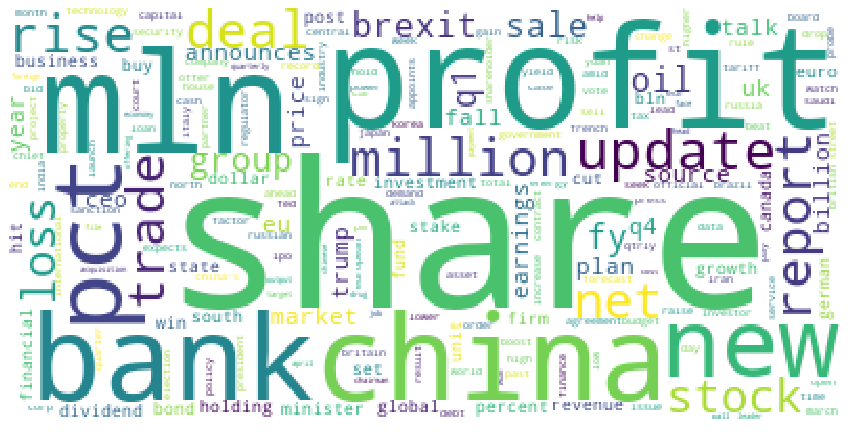

In [57]:
w = WordCloud(mode='RGBA',background_color='white').generate_from_frequencies(freqs)

plt.figure(figsize=(15,10))
plt.imshow(w)
plt.axis("off") 
plt.show()

# Visualization with Bokeh


In [58]:
# sort first
text_2018_sorted_by_date = text_2018.sort_values(by='date')

In [59]:
# make the DataFrame 'datetime' ready
text_2018_sorted_by_date['date'] = pd.to_datetime(text_2018_sorted_by_date.date)

In [60]:
# and then groupby for going through TextBlob
text_2018_sorted_by_date_blob = (sorted(text_2018_sorted_by_date.groupby(['date'])))

In [62]:
# since not all polarity and subjectivity can be taken on one day, i have calculated the average
def check_blob(df,txb_pol, txb_sub ):
    pol = []
    sub = []

    for i, t in df.iterrows(): 
        txb = TextBlob(t.title)
        pol.append(txb.polarity)
        sub.append(txb.subjectivity)
    txb_pol = np.mean(pol)
    txb_sub = np.mean(sub)

    return txb_pol, txb_sub

In [67]:
# Polarity and Subjectivity will be given into a list where each item in the list is an average
pol_per_date = []
sub_per_date = []
pol_blob = []
sub_blob = []
date_col = []

for i, item in text_2018_sorted_by_date_blob:
    
    pol_blob, sub_blob = check_blob(item.set_index('index'), pol_blob, sub_blob)
    pol_per_date.append(pol_blob)
    sub_per_date.append(sub_blob)
    # date is being formatted for better readability and further date-format for the visualization DataFrame 
    date_col.append(datetime.strftime(datetime.date(i), '%Y-%m-%d'))

In [89]:
# make dictionary and convert string Date time into Python Date time object for further plotting
visualization = {'Date': pd.to_datetime(date_col) , 'Polarity': pol_per_date, 'Subjectivity': sub_per_date }

In [100]:
# Import figure from bokeh.plotting
from bokeh.plotting import figure

source = ColumnDataSource(visualization)
sentiment = ['Polarity', 'Subjectivity']

# Create the figure: p
p = figure(plot_width=900, plot_height=400,x_axis_type='datetime')

# Plot Polarity and Subjectivity
p.circle(visualization['Date'], visualization['Polarity'], color='blue', size=10, legend_label='Polarity')
p.circle(visualization['Date'], visualization['Subjectivity'], color='green', size=10, legend_label='Subjectivity')
 
show(p)

In [111]:
#make parameters ready for plotting of the DJIA-index
max_volume = max(DJIA.Volume)
djia_by_date = DJIA.reset_index()
djia_by_date['Volume mln'] = djia_by_date['Volume']/1000000

source = ColumnDataSource(djia_by_date)

TOOLS = "pan, wheel_zoom, box_zoom, box_select,reset, save"

# Graph has date on the x-axis
p = figure(title="Scroll over the graph for 'Open' and 'Close' numbers", x_axis_type='datetime', tools=TOOLS)

p.line(x='Date', y='Volume mln', source=source) #build a line chart

p.yaxis.axis_label = 'Traded Volumes - Dow Jones stocks portfolio (mln)'

p.xgrid.grid_line_color = None

# add a hover tool and show the date in date time format
hover = HoverTool()
hover.tooltips=[
    ('Open', '@Open{0.2f}'),
    ('Close', '@Close{0.2f}')
]

p.add_tools(hover)

output_notebook() # show the output in jupyter notebook


Loading BokehJS ...

In [112]:
show(p)